# Purpose: Investigate the utility of ML clustering in developing a model that will predict Zillow's log error (log(Zestimate) - log(Sale Price))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import scipy.stats as stats

from wrangle import wrangle_zillow_cluster
from env import get_db_url
from acquire import zachs_zillow_pull
from evaluate import get_rmse
import prep
import cluster as cl

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

### Acquire and wrangle data.

Raw data acquired by SQL Query of the Codeup cloud database. Query pulled in 77,380 records.

Wrangling decisions took into account the project spec that the investigation be focused on Single Family Residential properties. Columns that had more than 67% null values and no suitable imputation options were dropped. The remaining null values were addressed by imputation. Columns that were determined to have redundant or irrelevant data were dropped. The 'prop_age' (property age) column was computed and replaced the 'yr_blt' (year built) column. The 'fips' column was renamed to 'county_name' and decoded to hold the human-readable names of the counties (LA, Orange, and Ventura) pursuant to these data. 

Clean dataframe ended up with 52,215 records.

In [3]:
df = zachs_zillow_pull()

df.info()
df.head()

Reading from CSV file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77380 non-null  int64  
 1   parcelid                      77380 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49671 non-null  float64
 9   calculatedbathnbr             76771 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77184

id  parcelid  airconditioningtypeid  architecturalstyletypeid  \
0  1727539  14297519                    NaN                       NaN   
1  1387261  17052889                    NaN                       NaN   
2    11677  14186244                    NaN                       NaN   
3  2288172  12177905                    NaN                       NaN   
4  1970746  10887214                    1.0                       NaN   

   basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0           NaN          3.5         4.0                  NaN   
1           NaN          1.0         2.0                  NaN   
2           NaN          2.0         3.0                  NaN   
3           NaN          3.0         4.0                  NaN   
4           NaN          3.0         3.0                  NaN   

   buildingqualitytypeid  calculatedbathnbr  decktypeid  \
0                    NaN                3.5         NaN   
1                    NaN                1.0         NaN   
2                    NaN                2.0         NaN   
3                    8.0                3.0         NaN   
4                    8.0                3.0         NaN   

   finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
0                       NaN                        3100.0   
1                    1465.0                        1465.0   
2                       NaN                        1243.0   
3                       NaN                        2376.0   
4                       NaN                        1312.0   

   finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  \
0                3100.0                   NaN                   NaN   
1                1465.0                   NaN                   NaN   
2                1243.0                   NaN                   NaN   
3                2376.0                   NaN                   NaN   
4                1312.0                   NaN                   NaN   

   finishedsquarefeet50  finishedsquarefeet6    fips  fireplacecnt  \
0                   NaN                  NaN  6059.0           NaN   
1                1465.0                  NaN  6111.0           1.0   
2                   NaN                  NaN  6059.0           NaN   
3                   NaN                  NaN  6037.0           NaN   
4                   NaN                  NaN  6037.0           NaN   

   fullbathcnt  garagecarcnt  garagetotalsqft  hashottuborspa  \
0          3.0           2.0            633.0             NaN   
1          1.0           1.0              0.0             NaN   
2          2.0           2.0            440.0             NaN   
3          3.0           NaN              NaN             NaN   
4          3.0           NaN              NaN             NaN   

   heatingorsystemtypeid    latitude    longitude  lotsizesquarefeet  poolcnt  \
0                    NaN  33634931.0 -117869207.0             4506.0      NaN   
1                    NaN  34449266.0 -119281531.0            12647.0      NaN   
2                    NaN  33886168.0 -117823170.0             8432.0      1.0   
3                    2.0  34245180.0 -118240722.0            13038.0      1.0   
4                    2.0  34185120.0 -118414640.0           278581.0      1.0   

   poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7  \
0          NaN           NaN          NaN          NaN   
1          NaN           NaN          NaN          NaN   
2          NaN           NaN          NaN          1.0   
3          NaN           NaN          NaN          1.0   
4          NaN           NaN          NaN          1.0   

  propertycountylandusecode  propertylandusetypeid propertyzoningdesc  \
0                       122                  261.0                NaN   
1                      1110                  261.0                NaN   
2                       122                  261.0                NaN   
3                      0101                  261.0         LCR110000*   
4               

In [4]:
clean_df = wrangle_zillow_cluster(df)

clean_df.info()
clean_df.head()

Reading from CSV file...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52215 entries, 0 to 77379
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcel_id         52215 non-null  int64  
 1   baths             52215 non-null  float64
 2   beds              52215 non-null  int64  
 3   bldg_qual         52215 non-null  int64  
 4   calc_bath         52215 non-null  float64
 5   calc_fin_sqft     52215 non-null  float64
 6   fin_sqft_12       52215 non-null  float64
 7   county_name       52215 non-null  object 
 8   full_bath_ct      52215 non-null  int64  
 9   heat_sys          52215 non-null  int64  
 10  lat               52215 non-null  float64
 11  long              52215 non-null  float64
 12  has_pool          52215 non-null  uint8  
 13  county_prop_code  52215 non-null  object 
 14  zip               52215 non-null  int64  
 15  room_ct           52215 non-null  int64  
 16  unit_ct        

parcel_id  baths  beds  bldg_qual  calc_bath  calc_fin_sqft  fin_sqft_12  \
0   14297519    3.5     4          6        3.5         3100.0       3100.0   
1   17052889    1.0     2          6        1.0         1465.0       1465.0   
2   14186244    2.0     3          6        2.0         1243.0       1243.0   
3   12177905    3.0     4          8        3.0         2376.0       2376.0   
6   12095076    3.0     4          9        3.0         2962.0       2962.0   

      county_name  full_bath_ct  heat_sys         lat         long  has_pool  \
0   Orange County             3        24  33634931.0 -117869207.0         0   
1  Ventura County             1        24  34449266.0 -119281531.0         0   
2   Orange County             2        24  33886168.0 -117823170.0         1   
3       LA County             3         2  34245180.0 -118240722.0         1   
6       LA County             3         2  34145202.0 -118179824.0         1   

  county_prop_code    zip  room_ct  unit_ct  has_firepl    tax_val   log_err  \
0              122  96978        0        1           0  1023282.0  0.025595   
1             1110  97099        5        1           0   464000.0  0.055619   
2              122  97078        6        1           0   564778.0  0.005383   
3             0101  96330        0        1           0   145143.0 -0.103410   
6             0101  96293        0        1           0   773303.0 -0.001011   

  transact_date heat_sys_desc             prop_land_desc  prop_age  
0    2017-01-01           Yes  Single Family Residential        19  
1    2017-01-01           Yes  Single Family Residential        50  
2    2017-01-01           Yes  Single Family Residential        55  
3    2017-01-01       Central  Single Family Residential        47  
6    2017-01-01       Central  Single Family Residential        67

### Quick univariate survey of distributions

In [5]:
#Assign numeric variables to a list
num_vars = clean_df.select_dtypes(include=np.number).columns.to_list()

#View list to select variables we want to see
num_vars

['parcel_id',
 'baths',
 'beds',
 'bldg_qual',
 'calc_bath',
 'calc_fin_sqft',
 'fin_sqft_12',
 'full_bath_ct',
 'heat_sys',
 'lat',
 'long',
 'has_pool',
 'zip',
 'room_ct',
 'unit_ct',
 'has_firepl',
 'tax_val',
 'log_err',
 'prop_age']

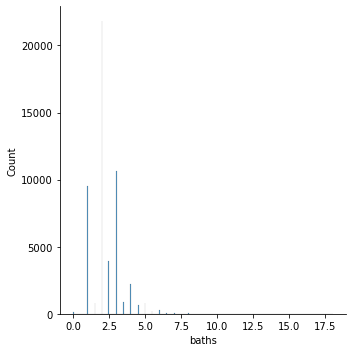

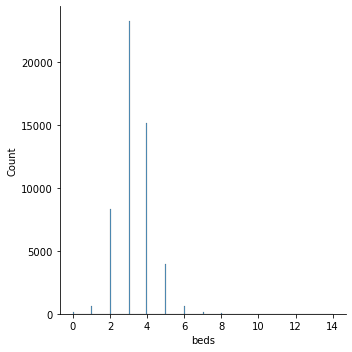

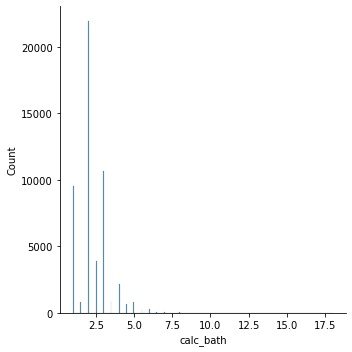

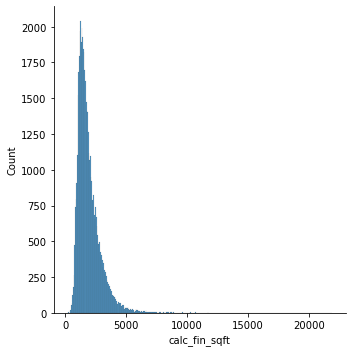

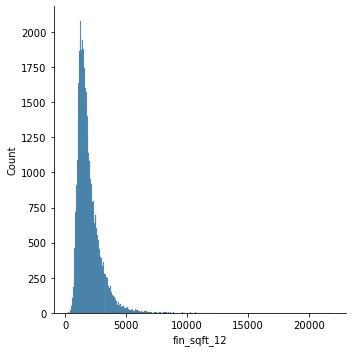

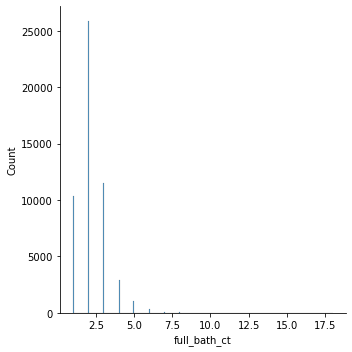

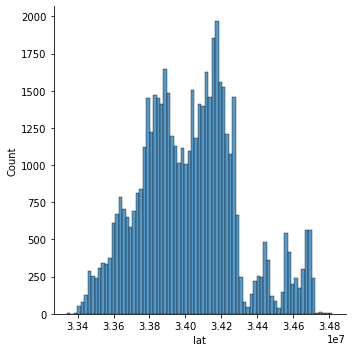

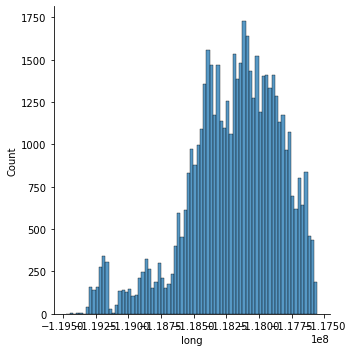

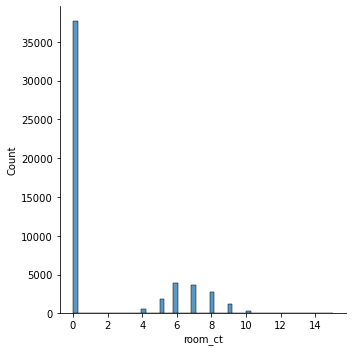

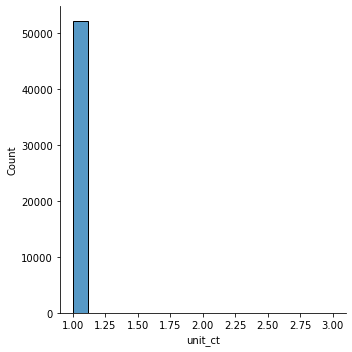

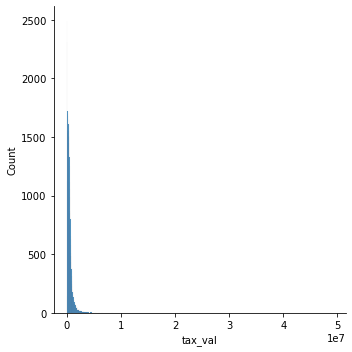

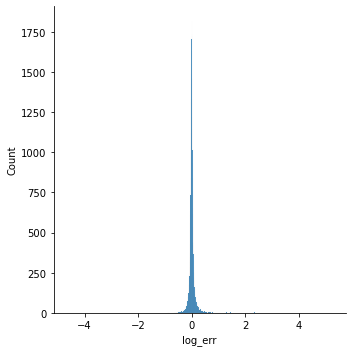

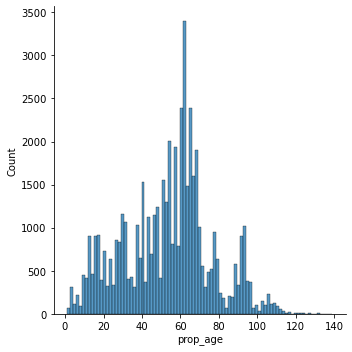

In [6]:
#Reassign num_vars with edited list of variables, removing variables that hold numeric designators that are really categories
num_vars = [
 'baths',
 'beds',
 'calc_bath',
 'calc_fin_sqft',
 'fin_sqft_12',
 'full_bath_ct',
 'lat',
 'long',
 'room_ct',
 'unit_ct',
 'tax_val',
 'log_err',
 'prop_age'
 ]

 #Loop through list and plot distributions

for var in num_vars:
    sns.displot(clean_df[var])
    plt.show()

In [7]:
clean_df[clean_df.room_ct > 0].county_name.value_counts().sort_index()

Orange County     10200
Ventura County     4341
Name: county_name, dtype: int64

### Takeaways: 'beds', 'baths', 'calc_bath', and 'full_bath_ct are semi-categorical but can still be used like continuous variables. 'calc_fin_sqft', 'fin_sqft_12', 'lat', 'long', and 'prop_age' are more traditionally continuous, though somewhat skewed. 

### 'log_err' is our target variable, and 'tax_val' is related to it, so they will have limited analytical use in later bivariate analysis on the train split; 'tax_val' will not be included as a feature for model selection because of its relation to the target. 

### The remaining variables, 'room_ct' and 'unit_ct', have more drastic skew that is likely due to differences in data collection between counties. 'room_ct', for example, appears to have been collected in Orange and Ventura counties, but not LA County, as seen in the cell above.

# Prepare data for analysis and modeling

In [8]:
#Split data
train, validate, test = prep.get_splits(clean_df)
#Check shapes to ensure everything is in order
print(train.shape, validate.shape, test.shape)

(29240, 24) (12532, 24) (10443, 24)


### Quick bivariate visualizations of categorical variables vs. log error

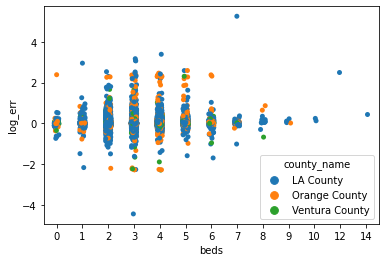

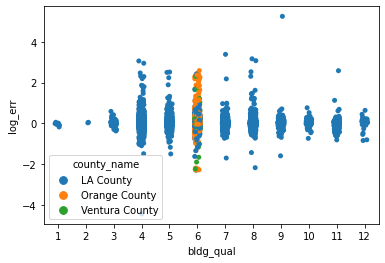

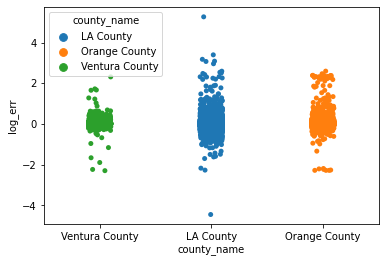

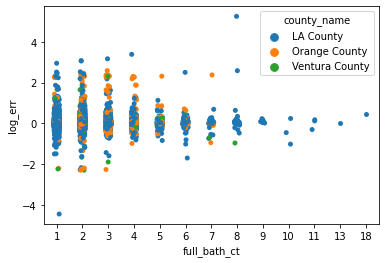

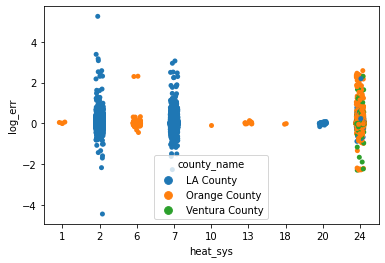

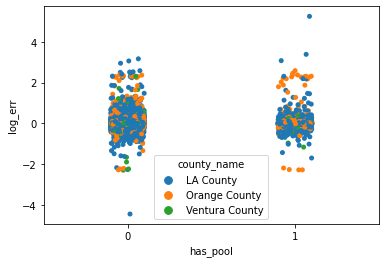

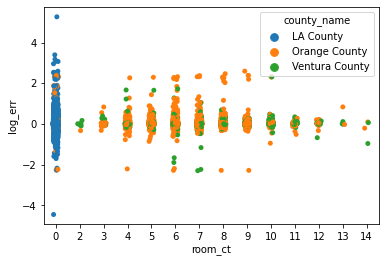

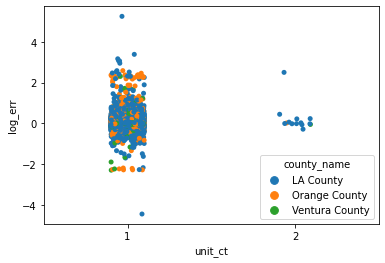

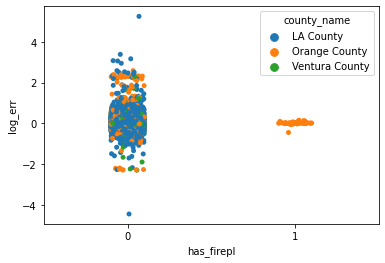

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Yes'),
  Text(1, 0, 'Central'),
  Text(2, 0, 'Floor/Wall'),
  Text(3, 0, 'Forced air'),
  Text(4, 0, 'Solar'),
  Text(5, 0, 'Baseboard'),
  Text(6, 0, 'None'),
  Text(7, 0, 'Radiant'),
  Text(8, 0, 'Gravity')])

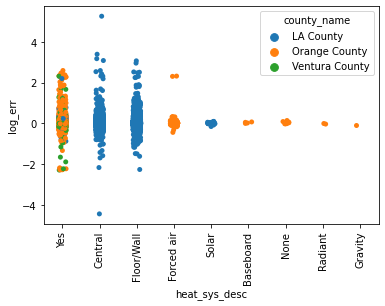

In [9]:
#Assign categorical and semi-categorical variables to list
cat_vars = train.select_dtypes(include=(np.uint8, np.int64, 'object')).columns.to_list()

#Edit list; remove 'parcel_id', 'county_prop_code', 'zip', 'transact_date', 'prop_land_desc', 'prop_age'
cat_vars =[
 'beds',
 'bldg_qual',
 'county_name',
 'full_bath_ct',
 'heat_sys',
 'has_pool',
 'room_ct',
 'unit_ct',
 'has_firepl',
 ]
#Loop through edited list to plot variables against log error
for var in cat_vars:
    sns.stripplot(data= train, x=train[var], y='log_err', hue= 'county_name', hue_order=['LA County', 'Orange County', 'Ventura County'])
    plt.show()

# Plot 'heat_sys_desc' outside of list to rotate xticks for legibility
sns.stripplot(data=train, x='heat_sys_desc', y='log_err', hue= 'county_name', hue_order=['LA County', 'Orange County', 'Ventura County'])
plt.xticks(rotation='vertical')

### Takeaways: There is further insight into the differences in data collection between counties in these stripplots, with 'county_name' highlighted. 'bldg_qual' and 'heat_sys_desc' are prime examples of metrics being collected in one place, but not the the other; 'bldg_qual' and 'heat_sys_desc' appear to have only been collected in LA County;'has_firepl' shows indications that its collection mostly took place in Orange County. Outliers are quickly noted as mostly coming from the LA County subset, as well.  

### Bivariate continuous variable analysis

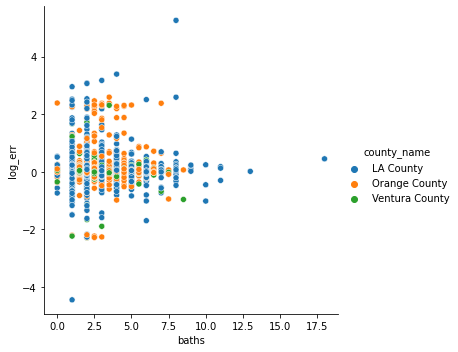

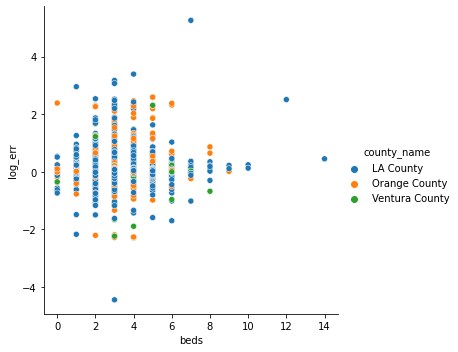

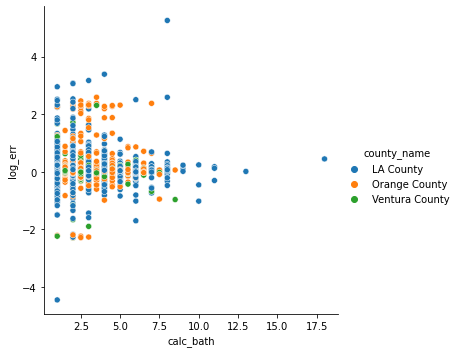

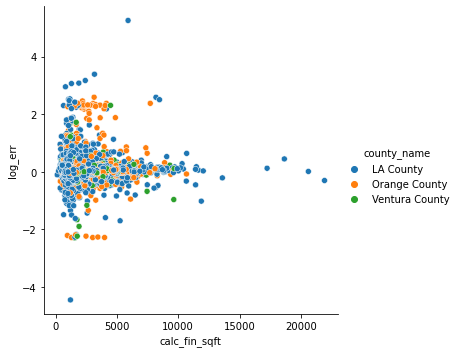

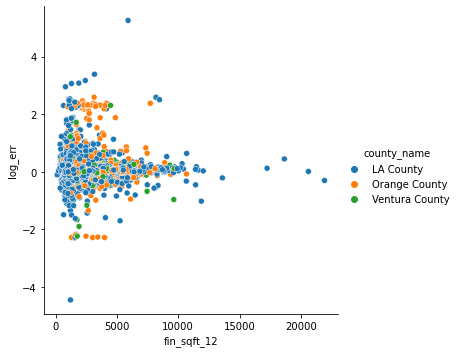

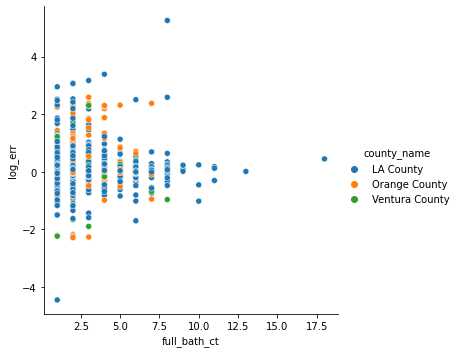

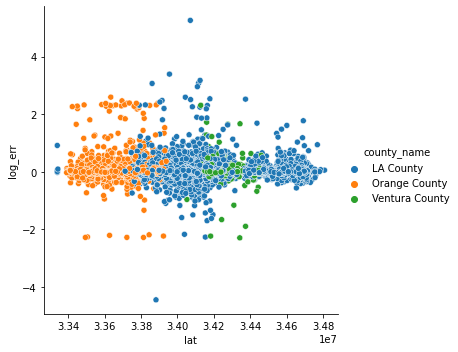

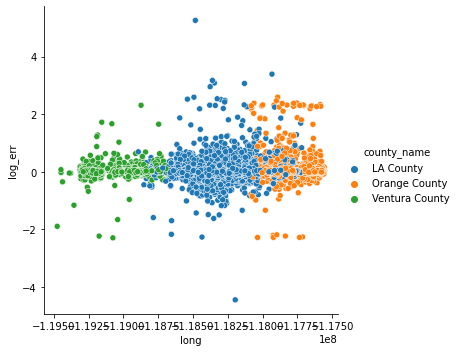

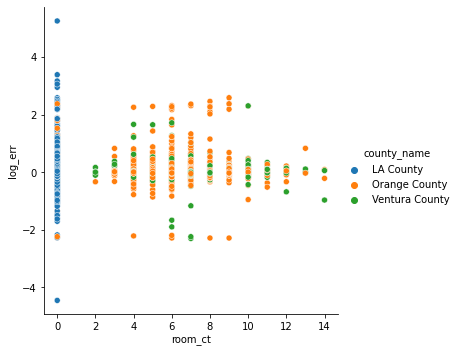

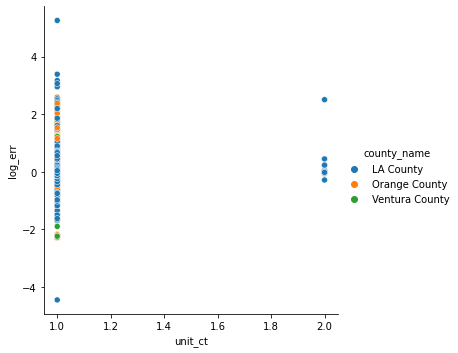

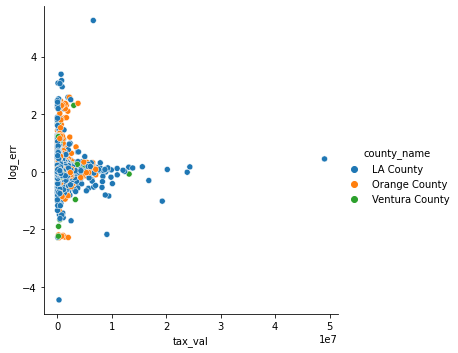

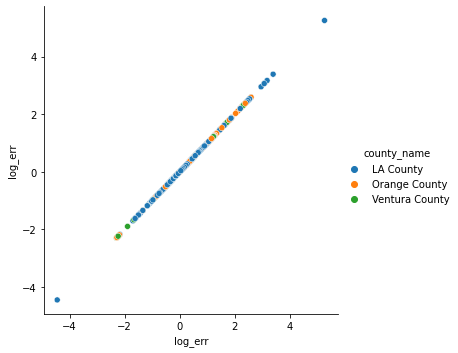

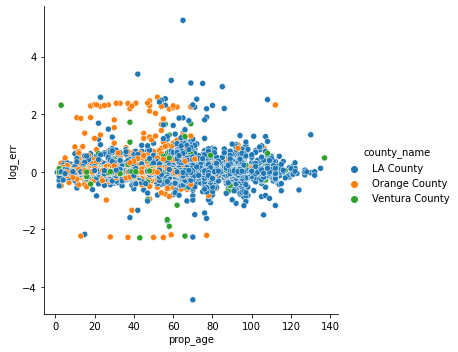

In [10]:
#Loop through list of continuous variables to plot against log_err
for var in num_vars:
    sns.relplot(data= train, x=train[var], y='log_err', hue= 'county_name', hue_order=['LA County', 'Orange County', 'Ventura County'])

### Takeaways: There is some clear, natural clustering in the graphs of latitude and longitude vs. log error.

### Is there a linear relationship between latitude (north-south movement) and log error?

$H_0:$ There is no linear relationship between latitude and log error.

$H_a:$ A linear relationship does exist between latitude and log error.

The correlation strength is -0.021, and our confidence level is 99.96%. We can reject the null hypothesis.


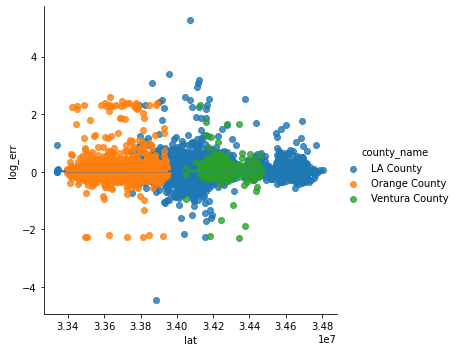

In [11]:
sns.lmplot(data= train, x='lat', y='log_err', hue='county_name', hue_order=['LA County', 'Orange County', 'Ventura County'])

alpha = 0.05

r_coeff, pval = stats.pearsonr(train.lat, train.log_err)

if pval < alpha:
    print(f'The correlation strength is {r_coeff:.3f}, and our confidence level is {1-pval:.2%}. We can reject the null hypothesis.')
else:
    print(f'We fail to reject the null hypothesis. The confidence level of {1-alpha:.2%} was not met; confidence level for this test was {1-pval:.2%}.')

### There is a linear relationship between latitude and log error, but it is not very strong.

### Is there a linear relationship between longitude (east-west movement) and log error?

$H_0:$ There is no linear relationship between longitude and log error.

$H_a:$ A linear relationship does exist between longitude and log error.

The correlation strength is 0.025, and our confidence level is 100.00%. We can reject the null hypothesis.


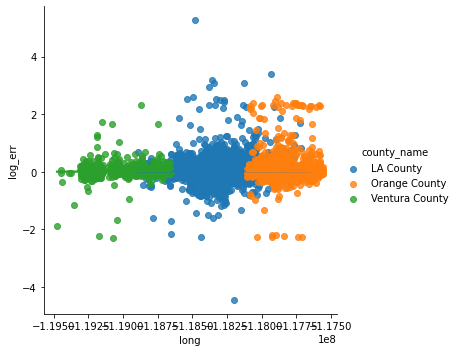

In [12]:
sns.lmplot(data= train, x='long', y='log_err', hue='county_name', hue_order=['LA County', 'Orange County', 'Ventura County'])

r_coeff, pval = stats.pearsonr(train.long, train.log_err)

if pval < alpha:
    print(f'The correlation strength is {r_coeff:.3f}, and our confidence level is {1-pval:.2%}. We can reject the null hypothesis.')
else:
    print(f'We fail to reject the null hypothesis. The confidence level of {1-alpha:.2%} was not met; confidence level for this test was {1-pval:.2%}.')

### There is also a linear relationship between longitude and log error, and it is also not very strong.

### Address outliers, train split only

In [13]:
#Compute IQR, upper and lower bounds
log_err_iqr = stats.iqr(train.log_err, scale=1)

print(f'Log error IQR: {log_err_iqr}')

log_err_q3 = train.log_err.quantile(.75)
log_err_q1 = train.log_err.quantile(.25)

print(f'Log error Q3 - stats computed IQR:{train.log_err.quantile(.75) - log_err_iqr:.3f}\nLog error Q3: {log_err_q3:.3f}\nLog error Q1:{log_err_q1:.3f}\nLog error Q3-Q1:{log_err_q3 - log_err_q1:.3f}')

Log error IQR: 0.065236198373875
Log error Q3 - stats computed IQR:-0.025
Log error Q3: 0.041
Log error Q1:-0.025
Log error Q3-Q1:0.065


In [14]:
#Assign subset of train split with log error in IQR
train_iqr = train[(train.log_err < log_err_q3) & (train.log_err > log_err_q1)]

train_iqr[num_vars].describe()

baths          beds     calc_bath  calc_fin_sqft   fin_sqft_12  \
count  14620.000000  14620.000000  14620.000000   14620.000000  14620.000000   
mean       2.300992      3.342271      2.302804    1889.822025   1891.002941   
std        0.910535      0.893129      0.907968     860.982870    860.105455   
min        0.000000      0.000000      1.000000     240.000000    240.000000   
25%        2.000000      3.000000      2.000000    1294.000000   1296.000000   
50%        2.000000      3.000000      2.000000    1683.000000   1686.000000   
75%        3.000000      4.000000      3.000000    2287.000000   2287.000000   
max       13.000000      9.000000     13.000000   20612.000000  20612.000000   

       full_bath_ct           lat          long       room_ct       unit_ct  \
count  14620.000000  1.462000e+04  1.462000e+04  14620.000000  14620.000000   
mean       2.227223  3.402020e+07 -1.181795e+08      2.094254      1.000410   
std        0.884969  2.859827e+05  3.724046e+05      3.240588      0.020255   
min        1.000000  3.334062e+07 -1.193049e+08      0.000000      1.000000   
25%        2.000000  3.381485e+07 -1.184017e+08      0.000000      1.000000   
50%        2.000000  3.400004e+07 -1.181206e+08      0.000000      1.000000   
75%        3.000000  3.420169e+07 -1.179007e+08      6.000000      1.000000   
max       13.000000  3.477966e+07 -1.175596e+08     13.000000      2.000000   

            tax_val       log_err      prop_age  
count  1.462000e+04  14620.000000  14620.000000  
mean   4.873085e+05      0.007129     50.330027  
std    5.314690e+05      0.017420     22.410141  
min    1.050400e+04     -0.024678      1.000000  
25%    2.119762e+05     -0.006967     32.750000  
50%    3.869605e+05      0.007044     53.000000  
75%    6.008035e+05      0.021015     65.000000  
max    2.385837e+07      0.040556    132.000000

In [15]:
validate_iqr = validate[(validate.log_err < validate.log_err.quantile(.75)) & (validate.log_err > validate.log_err.quantile(.25))]
test_iqr = test[(test.log_err < test.log_err.quantile(.75)) & (test.log_err > test.log_err.quantile(.25))]

### Run visualizations on IQR subset:

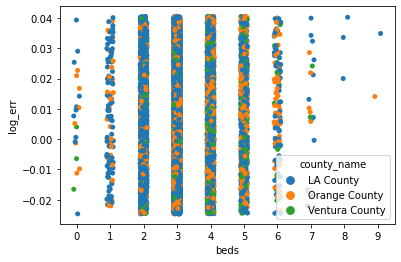

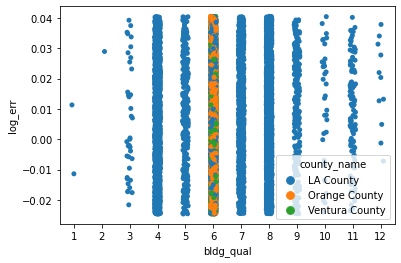

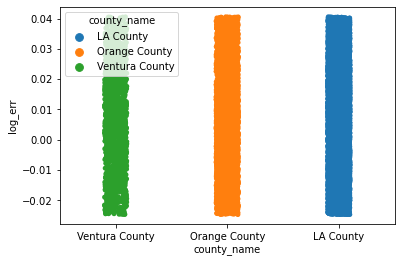

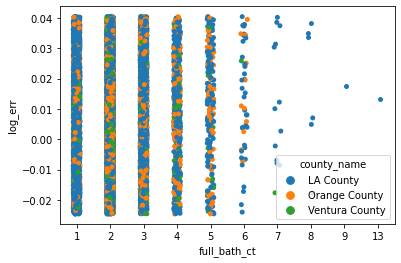

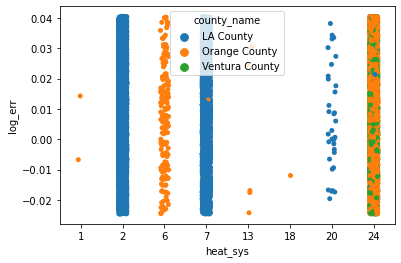

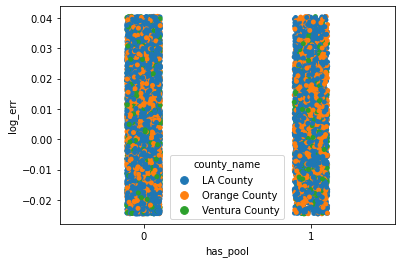

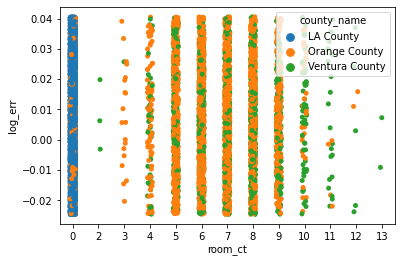

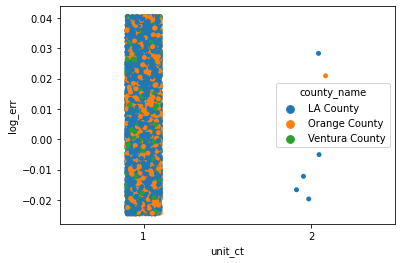

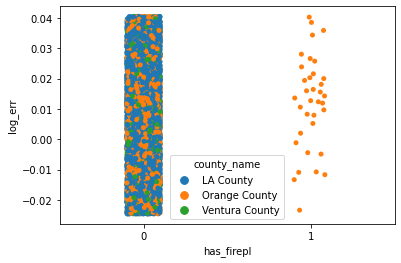

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Yes'),
  Text(1, 0, 'Floor/Wall'),
  Text(2, 0, 'Central'),
  Text(3, 0, 'Forced air'),
  Text(4, 0, 'Solar'),
  Text(5, 0, 'Baseboard'),
  Text(6, 0, 'None'),
  Text(7, 0, 'Radiant')])

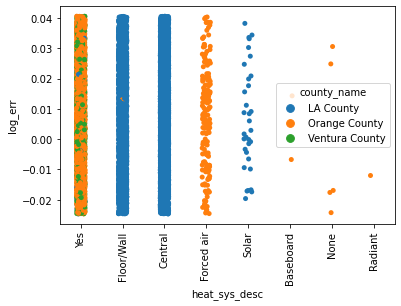

In [16]:
#Loop through edited list to plot categorical variables against log error (train split in log error IQR)
for var in cat_vars:
    sns.stripplot(data= train_iqr, x=train_iqr[var], y='log_err', hue= 'county_name', hue_order=['LA County', 'Orange County', 'Ventura County'])
    plt.show()

# Plot 'heat_sys_desc' outside of list to rotate xticks for legibility
sns.stripplot(data=train_iqr, x='heat_sys_desc', y='log_err', hue= 'county_name', hue_order=['LA County', 'Orange County', 'Ventura County'])
plt.xticks(rotation='vertical')

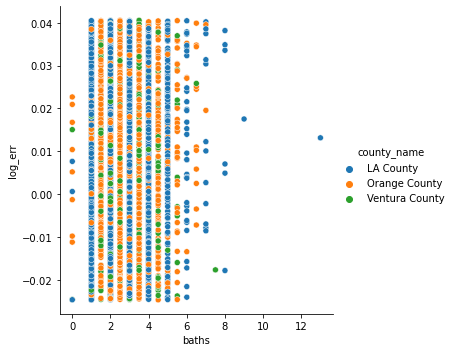

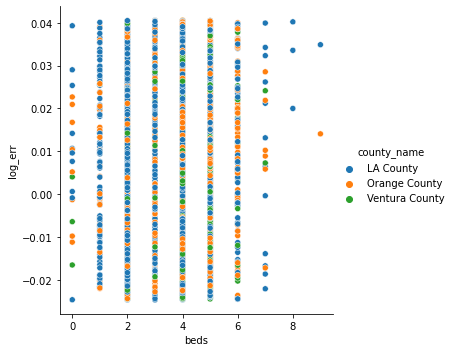

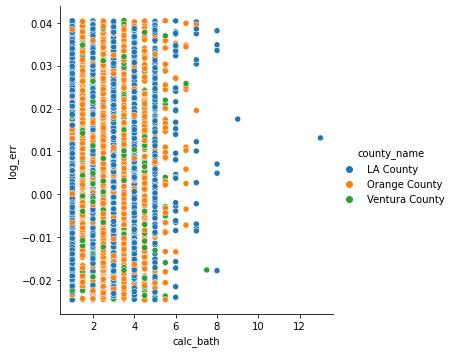

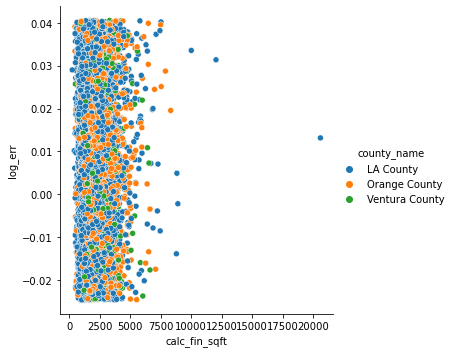

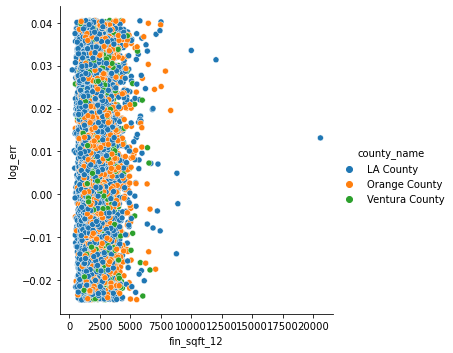

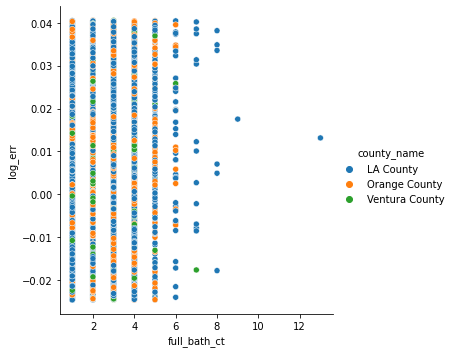

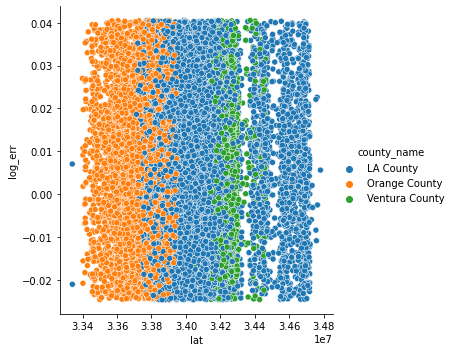

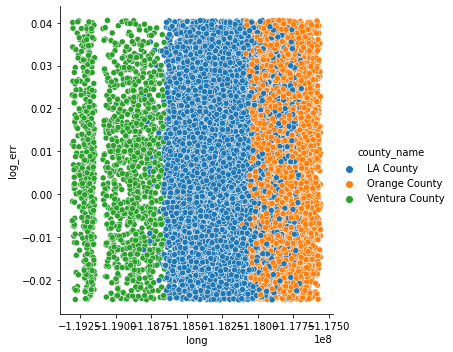

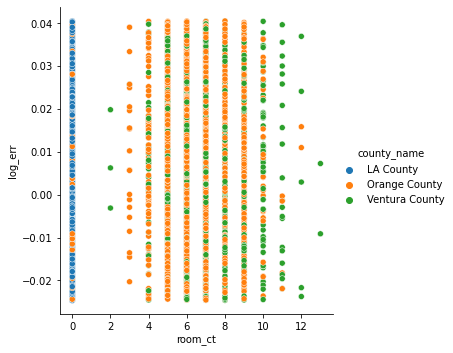

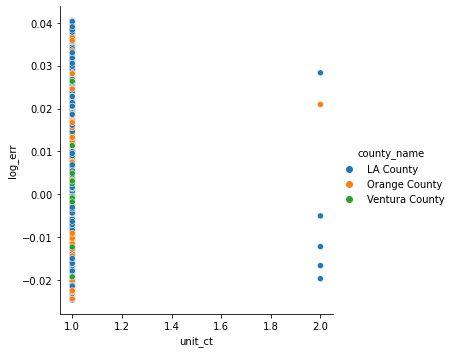

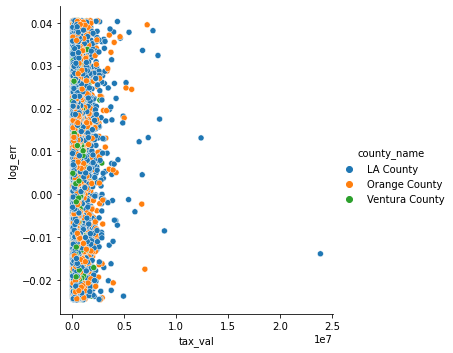

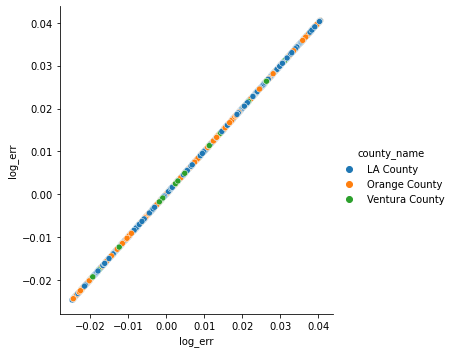

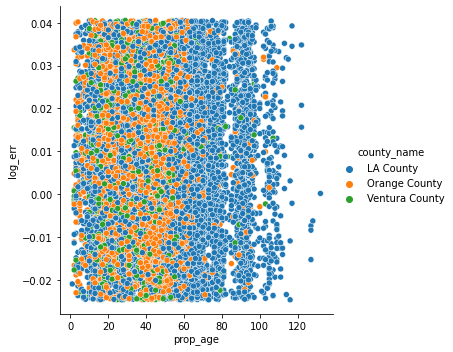

In [17]:
#Loop through list of continuous variables to plot against log_err
for var in num_vars:
    sns.relplot(data= train_iqr, x=train_iqr[var], y='log_err', hue= 'county_name', hue_order=['LA County', 'Orange County', 'Ventura County'])

### Resolve to scale and model clusters on both the full train split and the IQR subset of the train split.

In [18]:
#Isolate target to prepare for scaling and modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = prep.isolate_lm_target(train, validate, test, 'log_err')
X_train_iqr, y_train_iqr, X_validate_iqr, y_validate_iqr, X_test_iqr, y_test_iqr = prep.isolate_lm_target(train_iqr, validate_iqr, test_iqr, 'log_err')

In [19]:
X_train.columns

Index(['parcel_id', 'baths', 'beds', 'bldg_qual', 'calc_bath', 'calc_fin_sqft',
       'fin_sqft_12', 'county_name', 'full_bath_ct', 'heat_sys', 'lat', 'long',
       'has_pool', 'county_prop_code', 'zip', 'room_ct', 'unit_ct',
       'has_firepl', 'tax_val', 'transact_date', 'heat_sys_desc',
       'prop_land_desc', 'prop_age'],
      dtype='object')

### Scale X splits

In [20]:
# Select list of columns to scale
cols_to_scale = [
    'baths', 
    'beds', 
    'bldg_qual', 
    'calc_bath', 
    'calc_fin_sqft',
    'fin_sqft_12', 
    'full_bath_ct', 
    'heat_sys', 
    'lat', 
    'long',
    'has_pool', 
    'room_ct', 
    'unit_ct',
    'has_firepl',
    'prop_age'
    ]

# Minmax scale X splits with function from prep module
X_tr_scaled, X_val_scaled, X_test_scaled = prep.minmax_scale_data(X_train, X_validate, X_test, cols_to_scale)
X_tr_iqr_scaled, X_tr_iqr_val, X_tr_iqr_test = prep.minmax_scale_data(X_train_iqr, X_validate_iqr, X_test_iqr, cols_to_scale)

#Check head of scaled df
X_tr_iqr_scaled.head()


parcel_id     baths      beds  bldg_qual  calc_bath  calc_fin_sqft  \
47166   17128504  0.192308  0.444444   0.454545   0.125000       0.101021   
43898   14489865  0.153846  0.333333   0.454545   0.083333       0.054977   
10484   12730501  0.076923  0.333333   0.272727   0.000000       0.042902   
41932   14214771  0.192308  0.444444   0.454545   0.125000       0.083055   
1642    17201275  0.153846  0.444444   0.454545   0.083333       0.075299   

       fin_sqft_12     county_name  full_bath_ct  heat_sys       lat  \
47166     0.101021  Ventura County      0.083333   1.00000  0.611154   
43898     0.054977   Orange County      0.083333   1.00000  0.188942   
10484     0.042902       LA County      0.000000   0.26087  0.402053   
41932     0.083055   Orange County      0.083333   1.00000  0.342796   
1642      0.075299  Ventura County      0.083333   1.00000  0.647704   

           long  has_pool county_prop_code    zip   room_ct  unit_ct  \
47166  0.174716       0.0             1111  97091  0.615385      0.0   
43898  0.936122       0.0              122  96995  0.461538      0.0   
10484  0.736682       0.0             0100  96172  0.000000      0.0   
41932  0.862086       0.0              122  97065  0.000000      0.0   
1642   0.242020       0.0             1111  97097  0.615385      0.0   

       has_firepl   tax_val transact_date heat_sys_desc  \
47166         0.0  325368.0    2017-06-16           Yes   
43898         0.0  636853.0    2017-06-07           Yes   
10484         0.0  171811.0    2017-02-17    Floor/Wall   
41932         0.0  470966.0    2017-06-01           Yes   
1642          0.0  583000.0    2017-01-09           Yes   

                  prop_land_desc  prop_age  
47166  Single Family Residential  0.297710  
43898  Single Family Residential  0.374046  
10484  Single Family Residential  0.458015  
41932  Single Family Residential  0.167939  
1642   Single Family Residential  0.251908

In [21]:
#Final prep of scaled X splits before cluster modeling: remove non-numeric and unnecessary columns
X_tr_scaled = X_tr_scaled.select_dtypes(include=np.number)
X_val_scaled = X_val_scaled.select_dtypes(include=np.number)
X_test_scaled = X_test_scaled.select_dtypes(include=np.number)

X_tr_scaled.drop(columns= ['parcel_id', 'tax_val'], inplace=True)
X_val_scaled.drop(columns= ['parcel_id', 'tax_val'], inplace=True)
X_test_scaled.drop(columns= ['parcel_id', 'tax_val'], inplace=True)

X_tr_scaled.columns

Index(['baths', 'beds', 'bldg_qual', 'calc_bath', 'calc_fin_sqft',
       'fin_sqft_12', 'full_bath_ct', 'heat_sys', 'lat', 'long', 'has_pool',
       'zip', 'room_ct', 'unit_ct', 'has_firepl', 'prop_age'],
      dtype='object')

### Model clusters

In [22]:
#1st model, 3 clusters, use cluster_plucker function from cluster module that add model's prediction to train dataframe
cl.cluster_plucker(train, X_tr_scaled, 3)
train.rename(columns={'cluster_': 'cluster_1'}, inplace=True)
#Check train df for new cluster column
train.head()

parcel_id  baths  beds  bldg_qual  calc_bath  calc_fin_sqft  \
47166   17128504    2.5     4          6        2.5         2298.0   
64175   12852432    2.0     3          6        2.0         1400.0   
61285   12022559    3.0     3          7        3.0         2029.0   
50075   11599053    2.0     3          8        2.0         1512.0   
14064   14306587    2.0     3          6        2.0         1539.0   

       fin_sqft_12     county_name  full_bath_ct  heat_sys         lat  \
47166       2298.0  Ventura County             2        24  34220094.0   
64175       1400.0       LA County             2         2  33978648.0   
61285       2029.0       LA County             3         2  34101431.0   
50075       1512.0       LA County             2         2  34040630.0   
14064       1539.0   Orange County             2        24  33687758.0   

              long  has_pool county_prop_code    zip  room_ct  unit_ct  \
47166 -119000009.0         0             1111  97091        8        1   
64175 -117878079.0         0             0100  96492        0        1   
61285 -118388957.0         0             0100  96050        0        1   
50075 -118389152.0         0             0100  96015        0        1   
14064 -117791277.0         0              122  96941        6        1   

       has_firepl    tax_val   log_err transact_date heat_sys_desc  \
47166           0   325368.0  0.013072    2017-06-16           Yes   
64175           0   241917.0 -0.053325    2017-08-08       Central   
61285           0  1587306.0  0.064735    2017-07-27       Central   
50075           0  1119770.0 -0.143460    2017-06-23       Central   
14064           0   519967.0 -0.040782    2017-03-02           Yes   

                  prop_land_desc  prop_age  cluster_1  
47166  Single Family Residential        40          0  
64175  Single Family Residential        43          2  
61285  Single Family Residential        53          2  
50075  Single Family Residential        70          2  
14064  Single Family Residential        40          0

In [23]:
#2 more models, only adjusting cluster number
cl.cluster_plucker(train, X_tr_scaled, 2)
train.rename(columns={'cluster_': 'cluster_2'}, inplace=True)

cl.cluster_plucker(train, X_tr_scaled, 4)
train.rename(columns={'cluster_': 'cluster_3'}, inplace=True)


In [24]:
#Check head of train df for new cluster columns
train.head()

parcel_id  baths  beds  bldg_qual  calc_bath  calc_fin_sqft  \
47166   17128504    2.5     4          6        2.5         2298.0   
64175   12852432    2.0     3          6        2.0         1400.0   
61285   12022559    3.0     3          7        3.0         2029.0   
50075   11599053    2.0     3          8        2.0         1512.0   
14064   14306587    2.0     3          6        2.0         1539.0   

       fin_sqft_12     county_name  full_bath_ct  heat_sys         lat  \
47166       2298.0  Ventura County             2        24  34220094.0   
64175       1400.0       LA County             2         2  33978648.0   
61285       2029.0       LA County             3         2  34101431.0   
50075       1512.0       LA County             2         2  34040630.0   
14064       1539.0   Orange County             2        24  33687758.0   

              long  has_pool county_prop_code    zip  room_ct  unit_ct  \
47166 -119000009.0         0             1111  97091        8        1   
64175 -117878079.0         0             0100  96492        0        1   
61285 -118388957.0         0             0100  96050        0        1   
50075 -118389152.0         0             0100  96015        0        1   
14064 -117791277.0         0              122  96941        6        1   

       has_firepl    tax_val   log_err transact_date heat_sys_desc  \
47166           0   325368.0  0.013072    2017-06-16           Yes   
64175           0   241917.0 -0.053325    2017-08-08       Central   
61285           0  1587306.0  0.064735    2017-07-27       Central   
50075           0  1119770.0 -0.143460    2017-06-23       Central   
14064           0   519967.0 -0.040782    2017-03-02           Yes   

                  prop_land_desc  prop_age  cluster_1  cluster_2  cluster_3  
47166  Single Family Residential        40          0          0          2  
64175  Single Family Residential        43          2          0          3  
61285  Single Family Residential        53          2          0          0  
50075  Single Family Residential        70          2          0          0  
14064  Single Family Residential        40          0          0          2

### Plot cat variables against log error with clusters as hue

Cluster 1

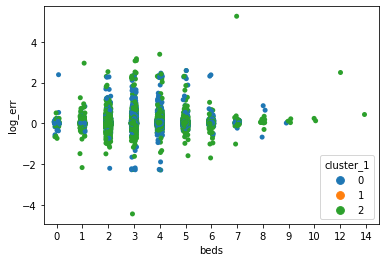

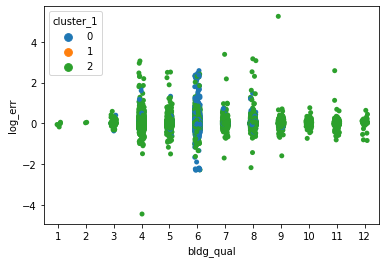

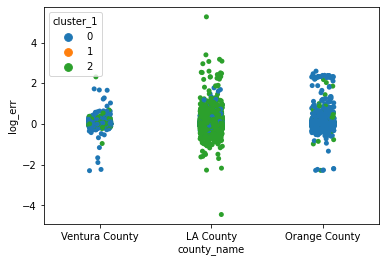

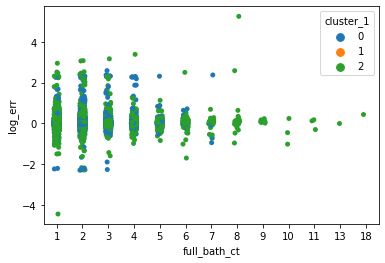

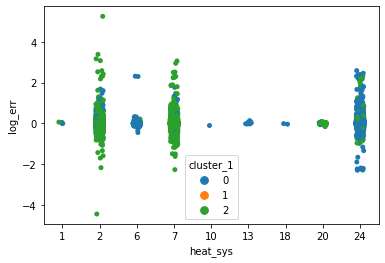

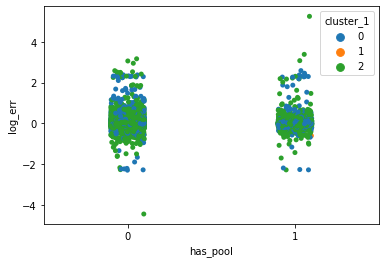

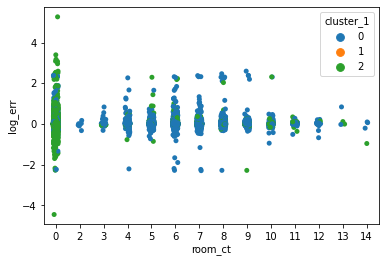

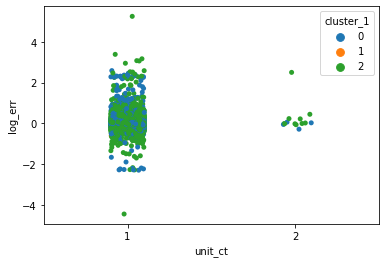

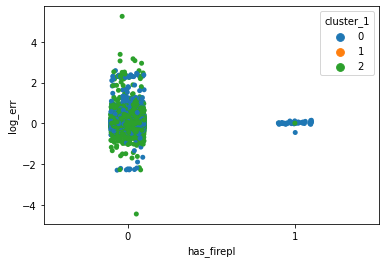

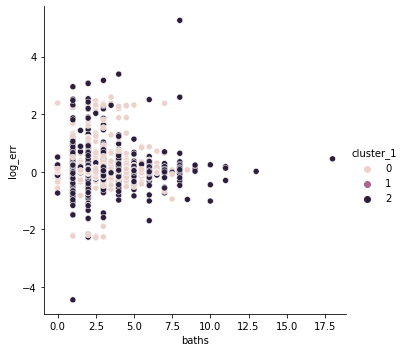

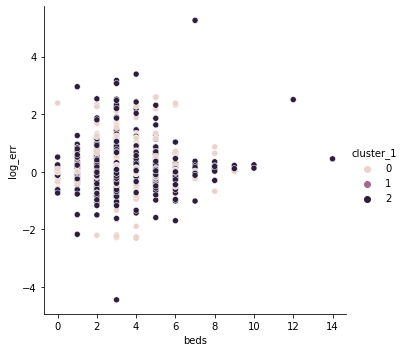

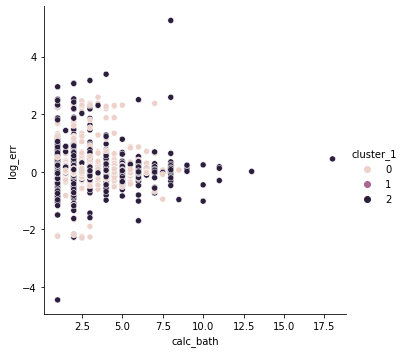

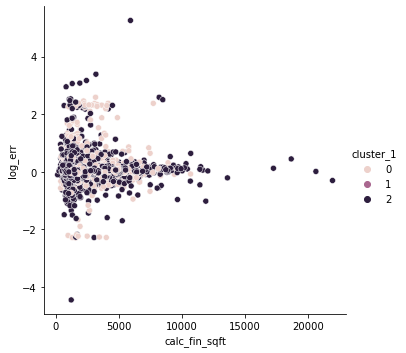

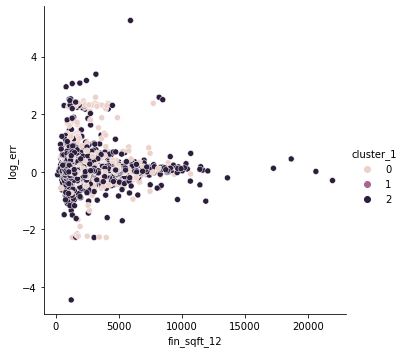

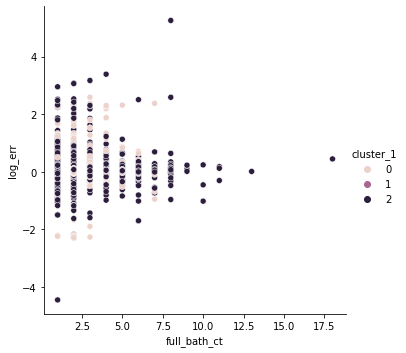

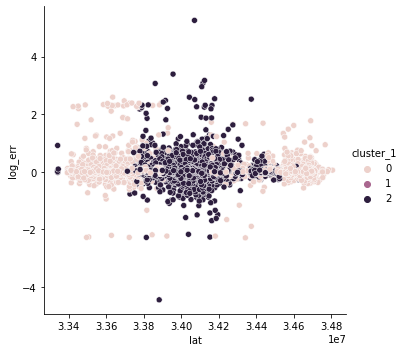

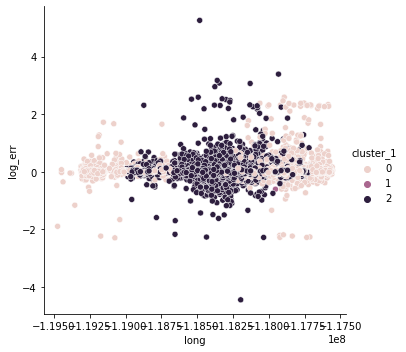

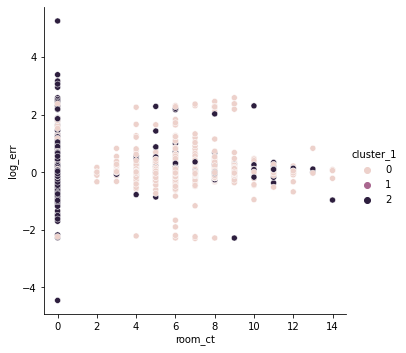

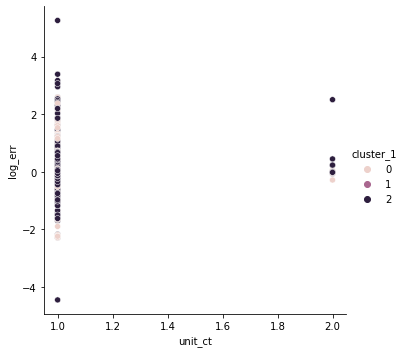

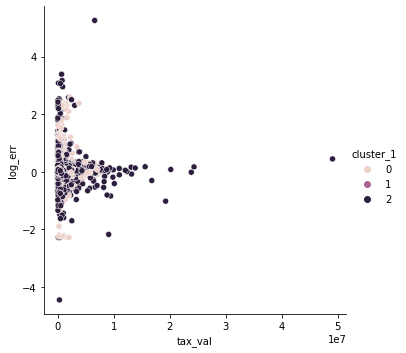

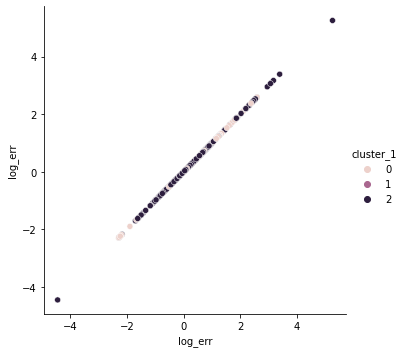

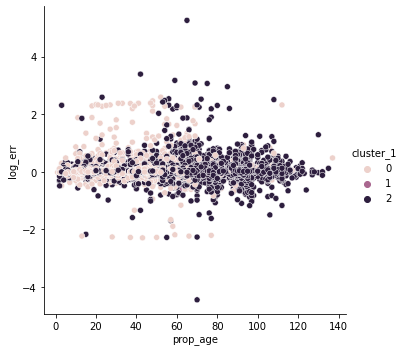

In [25]:
#Loop through list of categorical variables to visualize cluster groupings
for var in cat_vars:
    cl.viz_cluster(train, train[var], 'log_err', 'cluster_1')
    plt.show()

#Loop through list of continuous variables to visualize cluster groupings
for var in num_vars:
    cl.viz_cluster_bivariates(train, train[var], 'log_err', 'cluster_1')
    plt.show()


Cluster 2

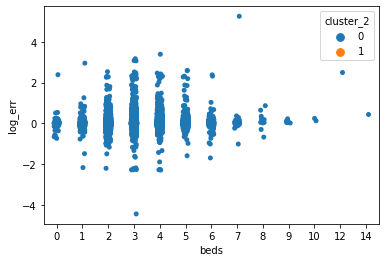

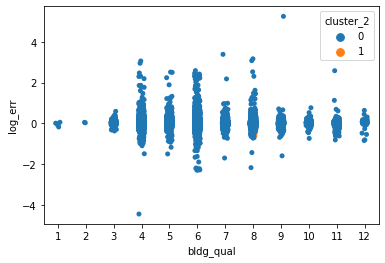

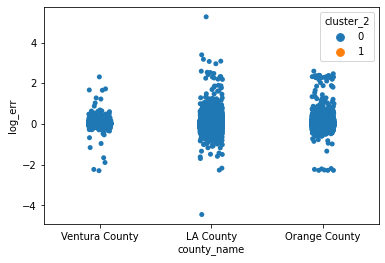

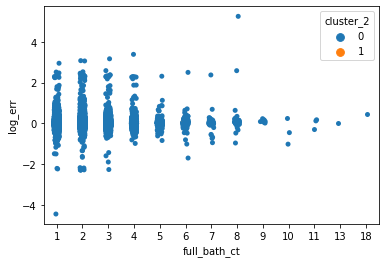

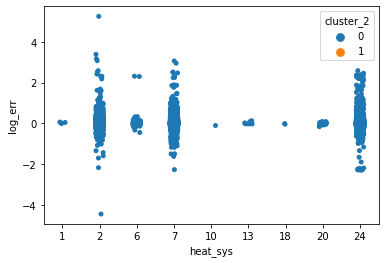

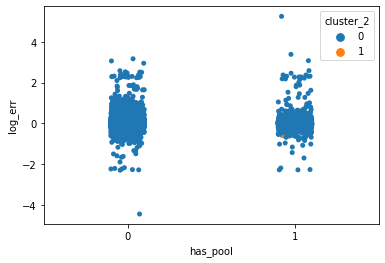

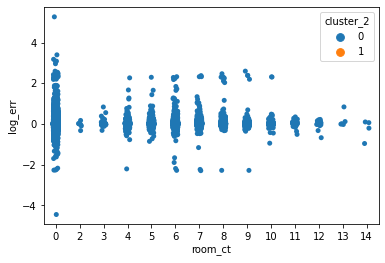

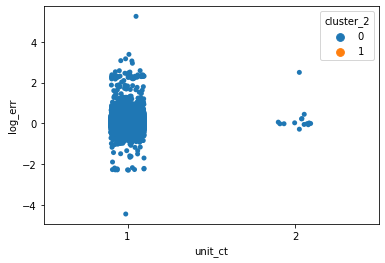

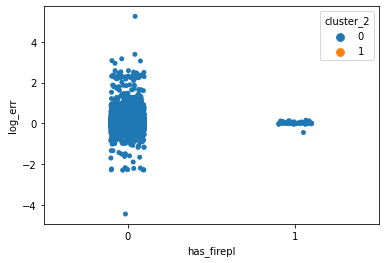

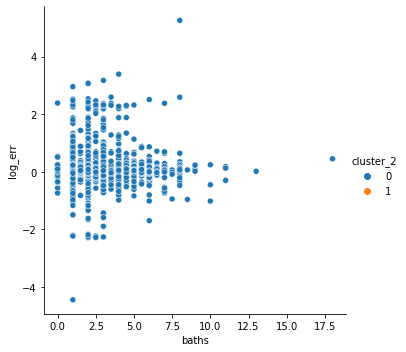

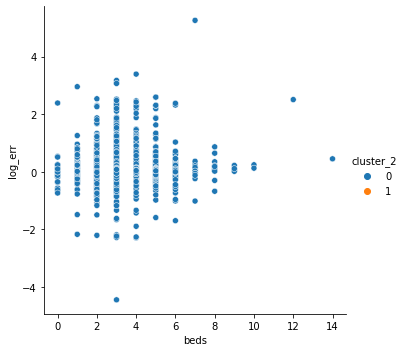

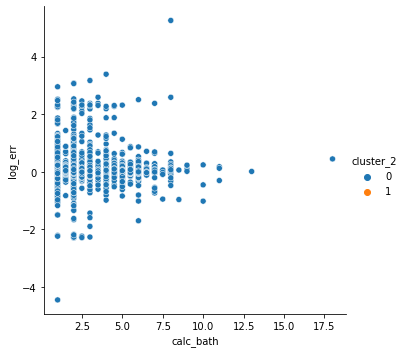

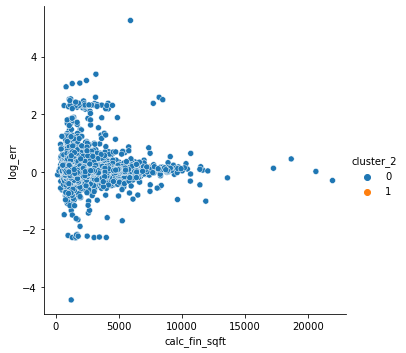

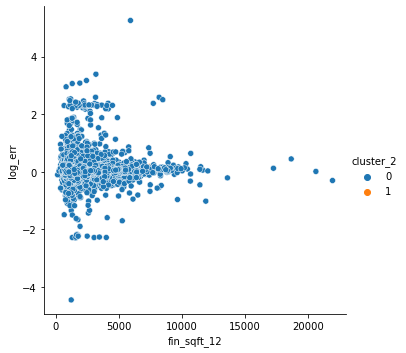

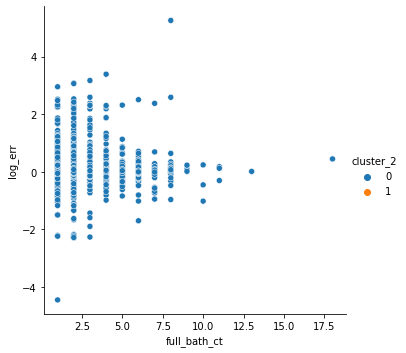

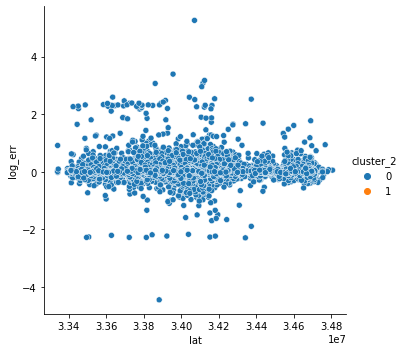

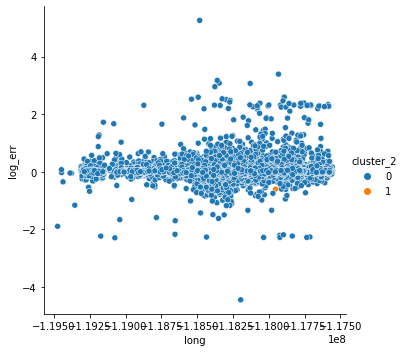

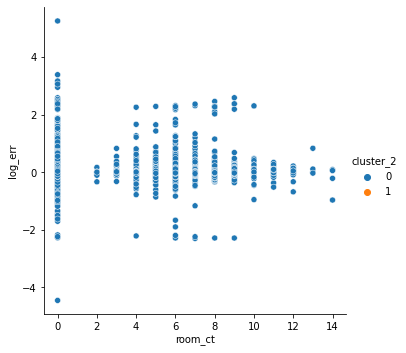

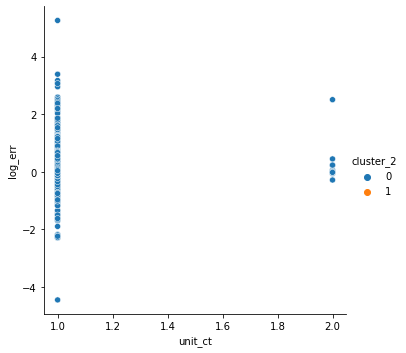

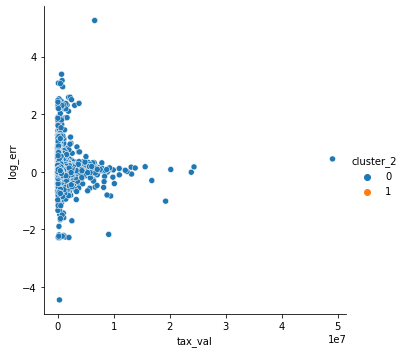

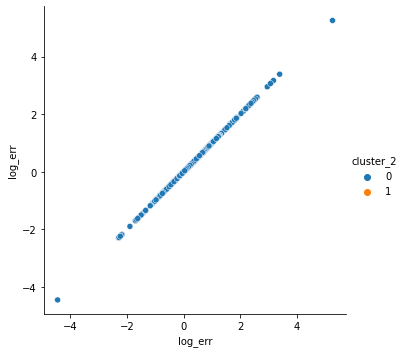

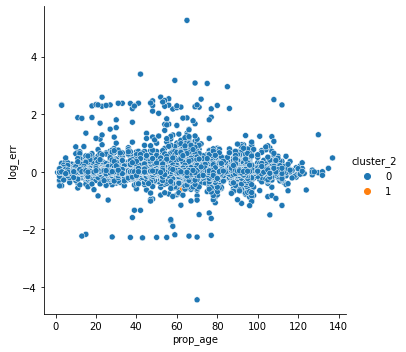

In [26]:
for var in cat_vars:
    cl.viz_cluster(train, train[var], 'log_err', 'cluster_2')
    plt.show()

for var in num_vars:
    cl.viz_cluster_bivariates(train, train[var], 'log_err', 'cluster_2')
    plt.show()

Cluster 3

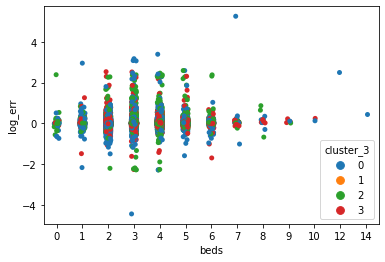

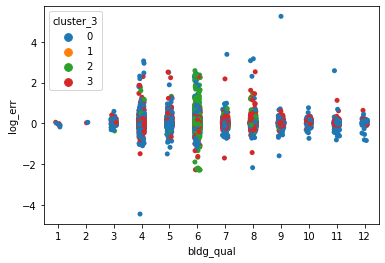

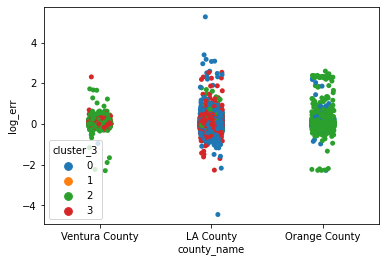

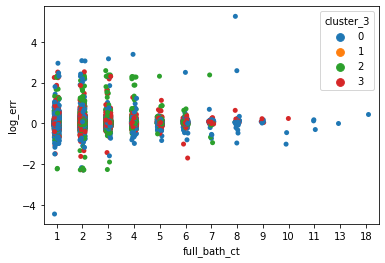

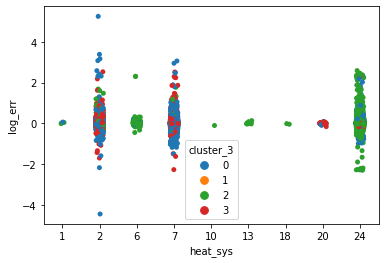

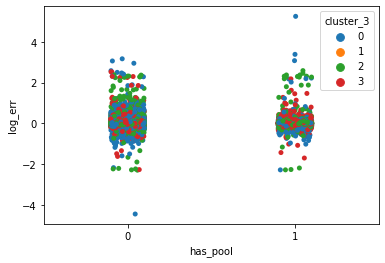

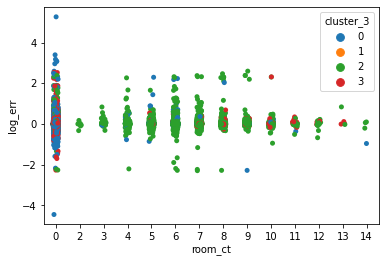

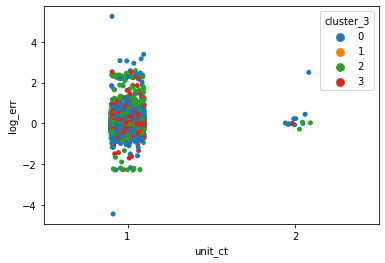

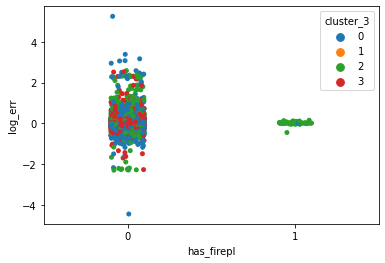

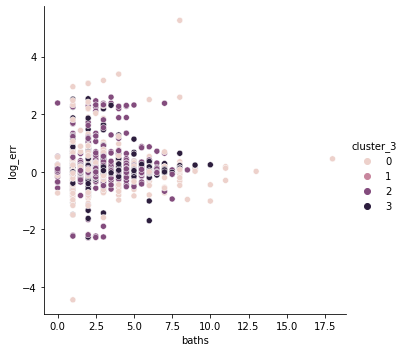

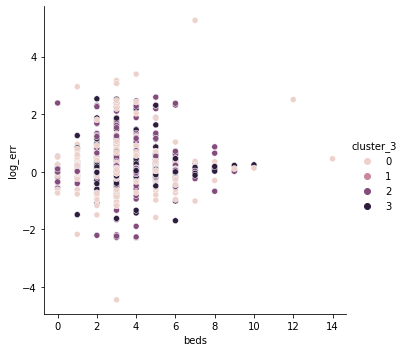

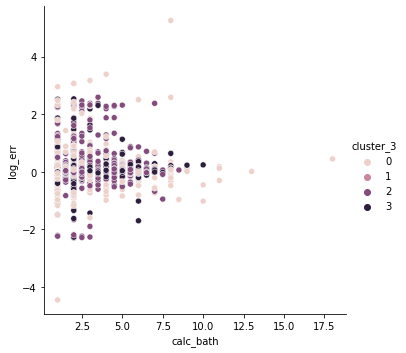

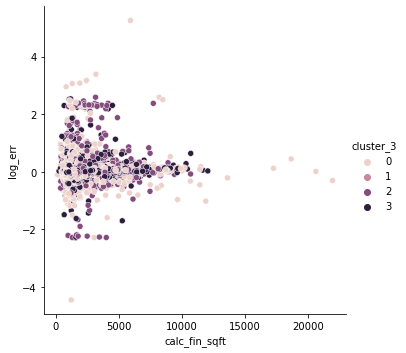

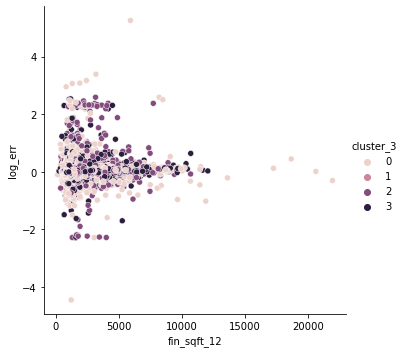

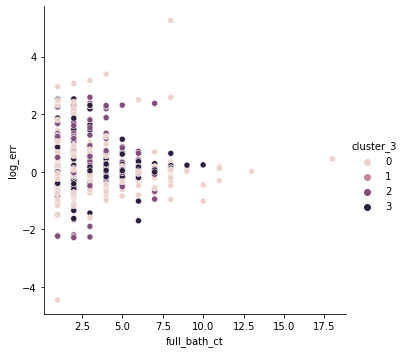

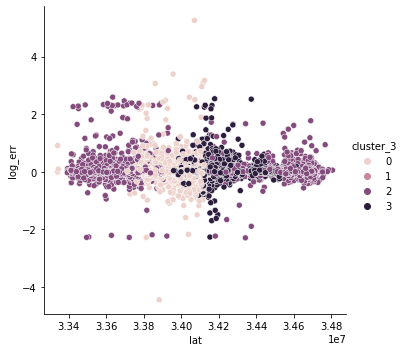

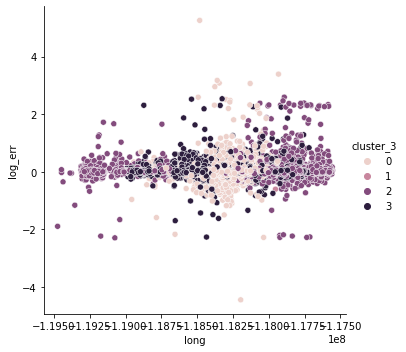

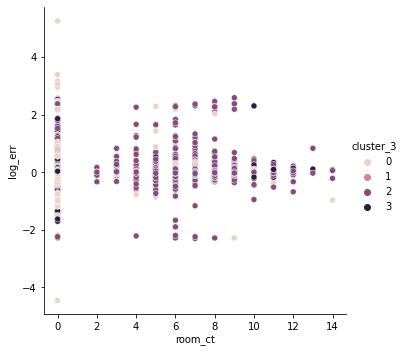

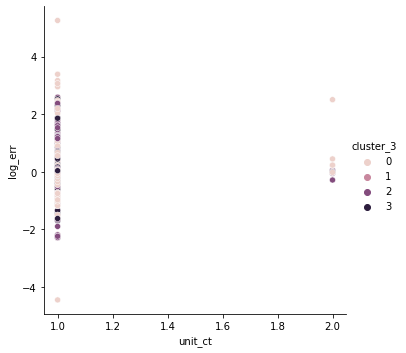

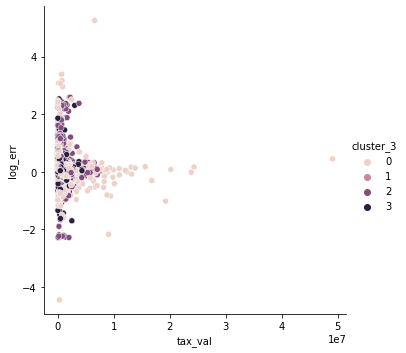

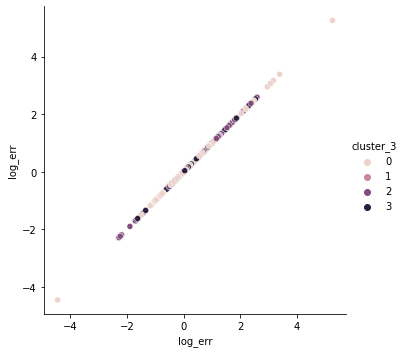

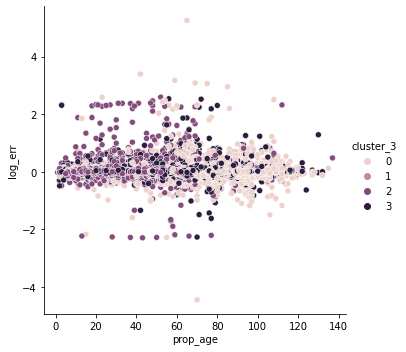

In [27]:
for var in cat_vars:
    cl.viz_cluster(train, train[var], 'log_err', 'cluster_3')
    plt.show()

for var in num_vars:
    cl.viz_cluster_bivariates(train, train[var], 'log_err', 'cluster_3')
    plt.show()

### Takeaways: Apart from latitude and longitude lining up as should be expected, no real patterns emerge from first three clusters.

### Cluster modeling with feature selection

In [28]:
#Use Select Kbest function from prep module
f_feature = prep.select_kbest(X_tr_scaled, y_train, 4)

print(f'Select K best picks(k=4): {f_feature}')

#Use RFE function from prep module
rfe_feature, rfe_ranked = prep.rfe(X_tr_scaled, y_train, 4)

print(f'RFE picks(k=4):{rfe_feature}')

Select K best picks(k=4): ['beds', 'calc_bath', 'calc_fin_sqft', 'fin_sqft_12']
RFE picks(k=4):['baths', 'calc_bath', 'calc_fin_sqft', 'fin_sqft_12']


In [29]:
#Cluster 4, with Select Kbest features
cl.cluster_plucker(train, X_tr_scaled[f_feature], 3)
train.rename(columns={'cluster_':'cluster_4'}, inplace=True)

#Cluster 5, with RFE features
cl.cluster_plucker(train, X_tr_scaled[rfe_feature], 3)
train.rename(columns={'cluster_':'cluster_5'}, inplace=True)

train.head()

parcel_id  baths  beds  bldg_qual  calc_bath  calc_fin_sqft  \
47166   17128504    2.5     4          6        2.5         2298.0   
64175   12852432    2.0     3          6        2.0         1400.0   
61285   12022559    3.0     3          7        3.0         2029.0   
50075   11599053    2.0     3          8        2.0         1512.0   
14064   14306587    2.0     3          6        2.0         1539.0   

       fin_sqft_12     county_name  full_bath_ct  heat_sys         lat  \
47166       2298.0  Ventura County             2        24  34220094.0   
64175       1400.0       LA County             2         2  33978648.0   
61285       2029.0       LA County             3         2  34101431.0   
50075       1512.0       LA County             2         2  34040630.0   
14064       1539.0   Orange County             2        24  33687758.0   

              long  has_pool county_prop_code    zip  room_ct  unit_ct  \
47166 -119000009.0         0             1111  97091        8        1   
64175 -117878079.0         0             0100  96492        0        1   
61285 -118388957.0         0             0100  96050        0        1   
50075 -118389152.0         0             0100  96015        0        1   
14064 -117791277.0         0              122  96941        6        1   

       has_firepl    tax_val   log_err transact_date heat_sys_desc  \
47166           0   325368.0  0.013072    2017-06-16           Yes   
64175           0   241917.0 -0.053325    2017-08-08       Central   
61285           0  1587306.0  0.064735    2017-07-27       Central   
50075           0  1119770.0 -0.143460    2017-06-23       Central   
14064           0   519967.0 -0.040782    2017-03-02           Yes   

                  prop_land_desc  prop_age  cluster_1  cluster_2  cluster_3  \
47166  Single Family Residential        40          0          0          2   
64175  Single Family Residential        43          2          0          3   
61285  Single Family Residential        53          2          0          0   
50075  Single Family Residential        70          2          0          0   
14064  Single Family Residential        40          0          0          2   

       cluster_4  cluster_5  
47166          1          1  
64175          0          0  
61285          1          1  
50075          0          0  
14064          0          0

Visualize Cluster 4

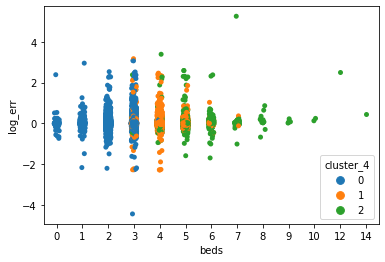

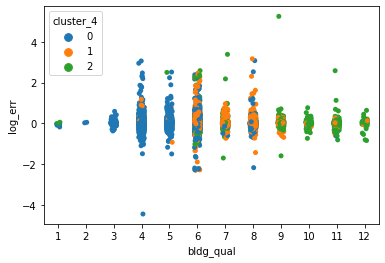

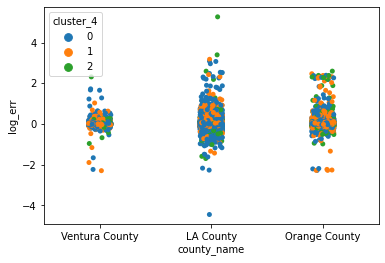

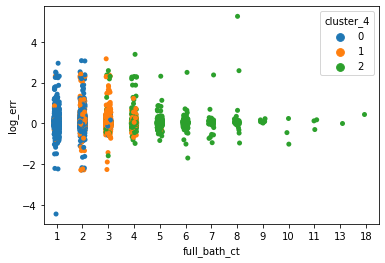

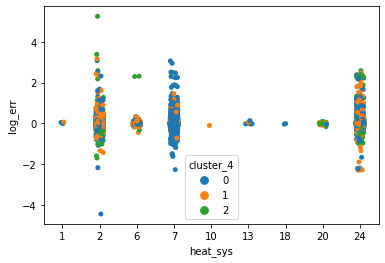

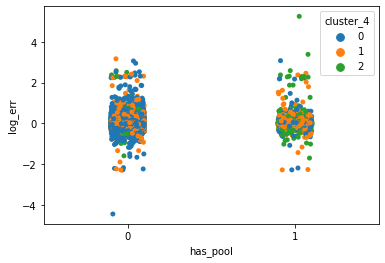

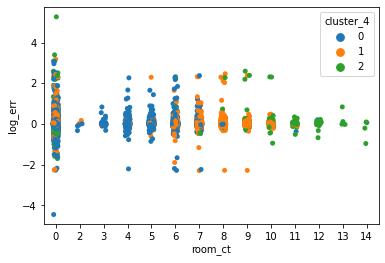

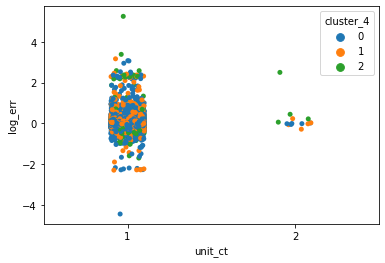

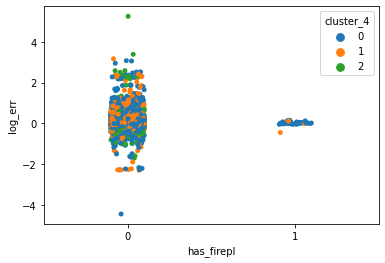

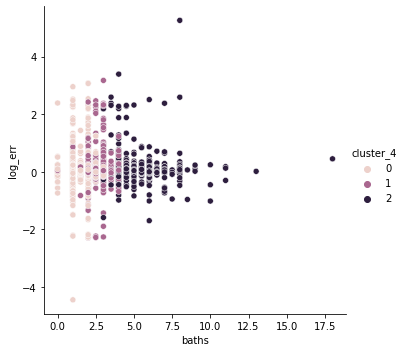

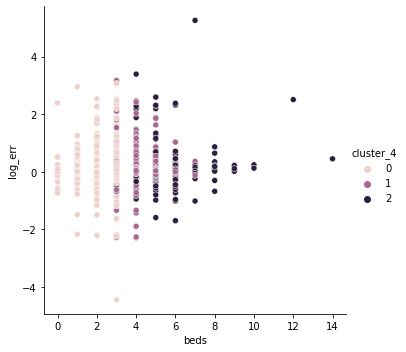

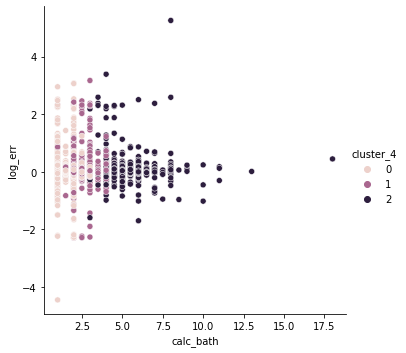

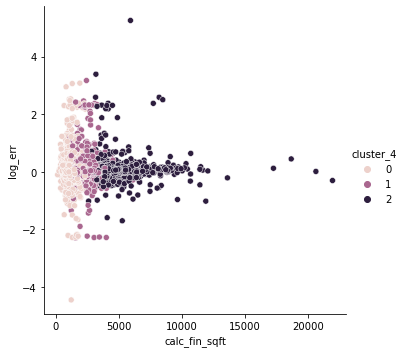

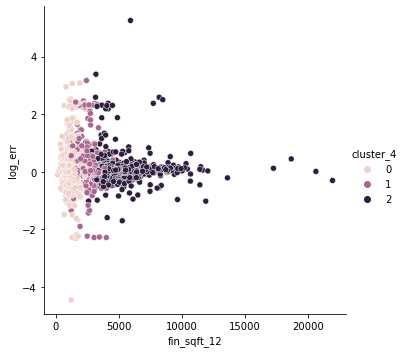

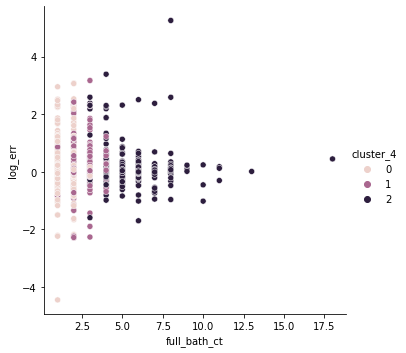

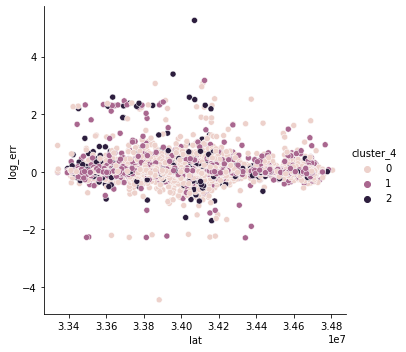

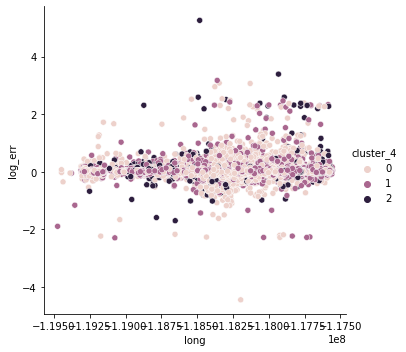

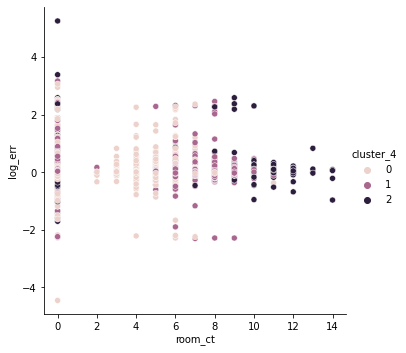

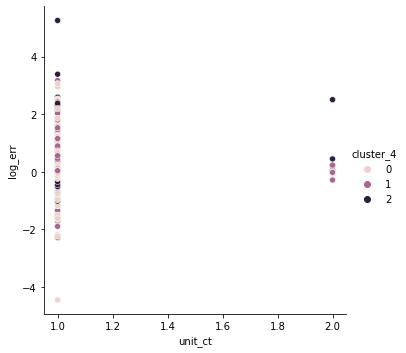

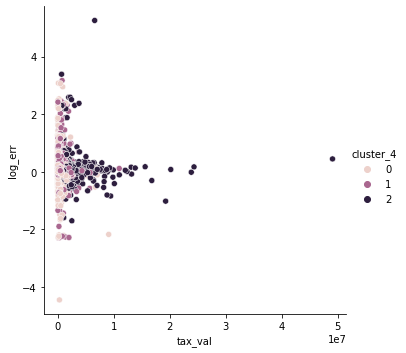

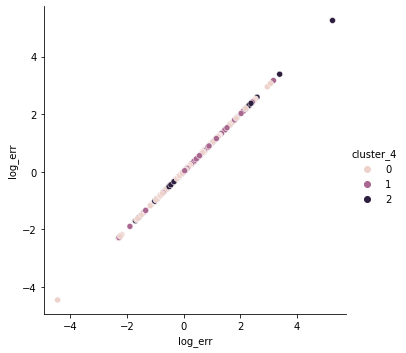

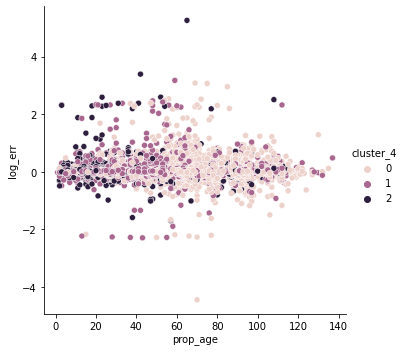

In [30]:
for var in cat_vars:
    cl.viz_cluster(train, train[var], 'log_err', 'cluster_4')
    plt.show()

for var in num_vars:
    cl.viz_cluster_bivariates(train, train[var], 'log_err', 'cluster_4')
    plt.show()

Visualize Cluster 5

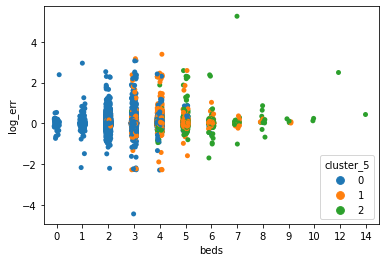

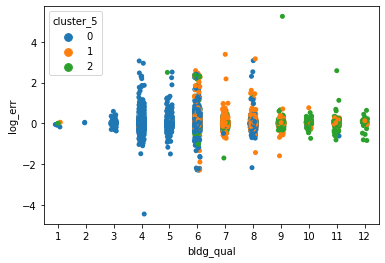

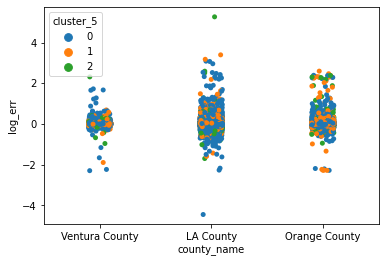

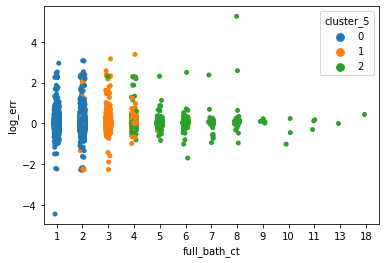

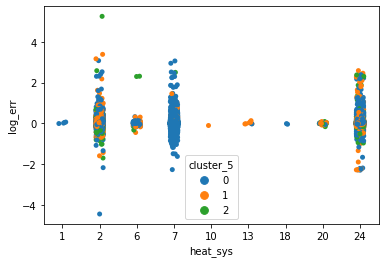

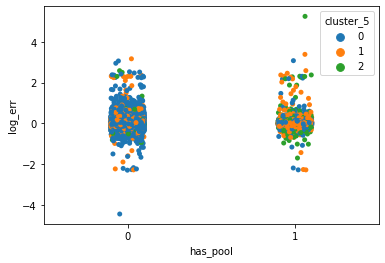

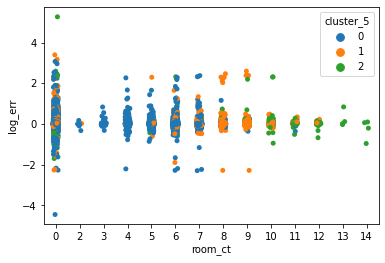

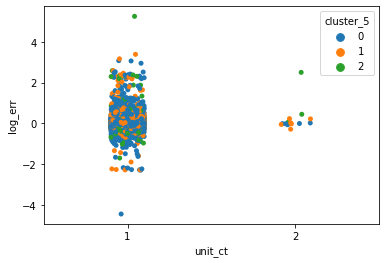

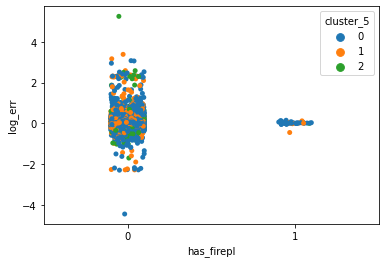

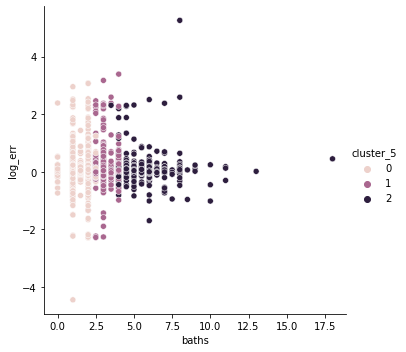

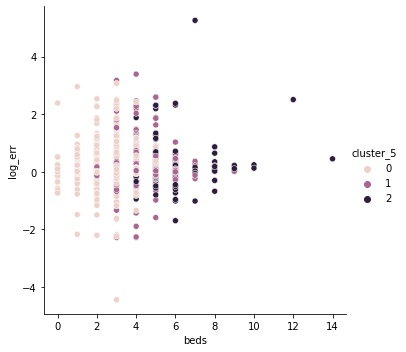

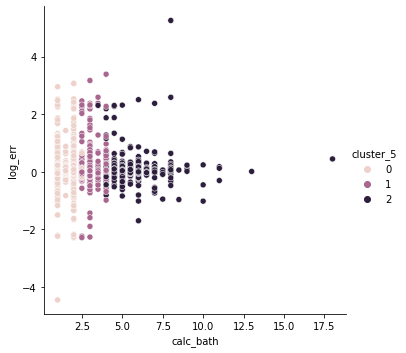

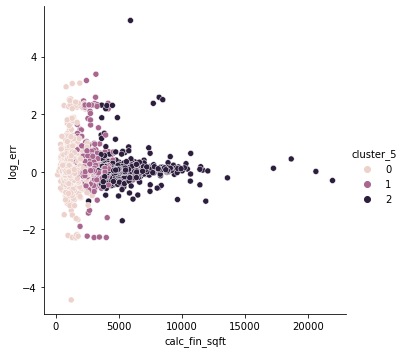

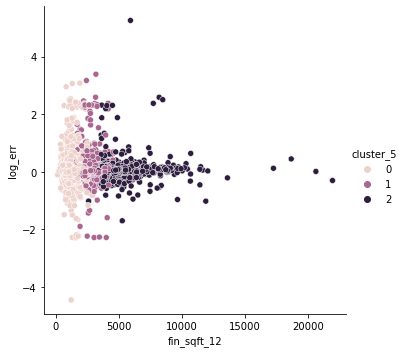

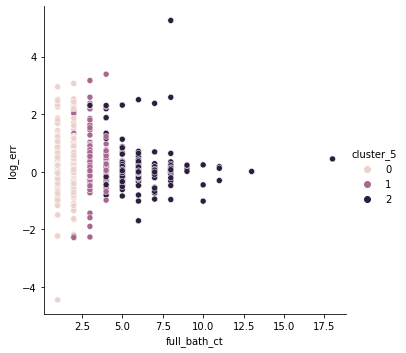

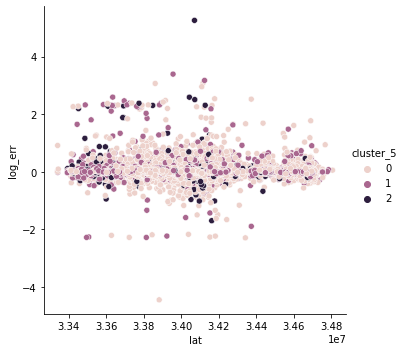

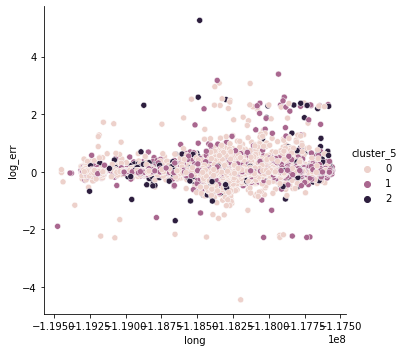

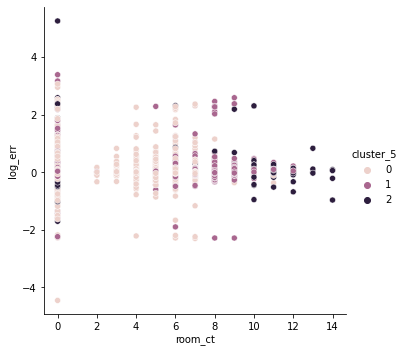

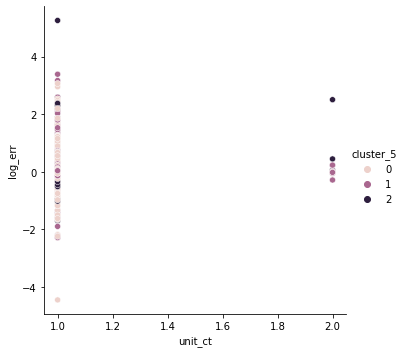

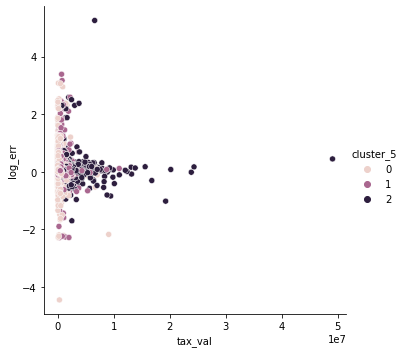

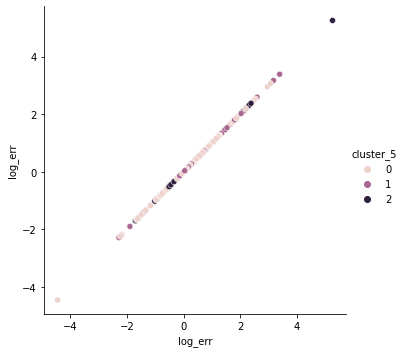

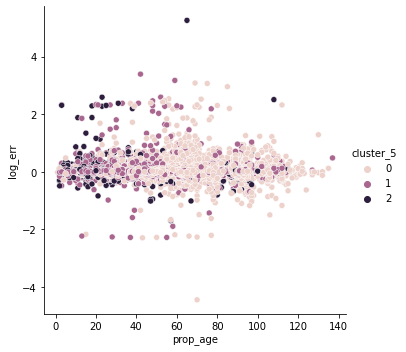

In [33]:
for var in cat_vars:
    cl.viz_cluster(train, train[var], 'log_err', 'cluster_5')
    plt.show()

for var in num_vars:
    cl.viz_cluster_bivariates(train, train[var], 'log_err', 'cluster_5')
    plt.show()

### Takeaways: The relplots for clusters 4 (Select Kbest features: 'beds', 'calc_bath', 'calc_fin_sqft', 'fin_sqft_12') and 5 (RFE features:'baths', 'calc_bath', 'calc_fin_sqft', 'fin_sqft_12') show some stratification, particularly for the square footage features. This seems to reflect conclusions at which we previously arrived for the best features to include in a regression model targeting assessed value of Single Family Residential properties.

# Regression modeling with the above conclusions in mind

In [32]:
#Establish baselines
lr1 = LinearRegression()
lr1.fit(X_tr_scaled, y_train)

y_train['med_bl'] = y_train.log_err.median()
y_train['mean_bl'] = y_train.log_err.mean()
y_train['yhat'] = lr1.predict(X_tr_scaled)

In [35]:
#Make regression models based on conclusions from clusters 4 and 5
lr2 = LinearRegression()
lr2.fit(X_tr_scaled[f_feature], y_train)

y_train['yhat_skb'] = lr2.predict(X_tr_scaled[f_feature])

lr3 = LinearRegression()
lr3.fit(X_tr_scaled[rfe_feature], y_train)

y_train['yhat_rfe'] = lr3.predict(X_tr_scaled[rfe_feature])

#Composite of features used in clusters 4 and 5
lr4= LinearRegression()
lr4.fit(X_tr_scaled['calc_bath', 'calc_fin_sqft', 'fin_sqft_12'], y_train)

y_train['yhat_comp'] = lr4.predict(X_tr_scaled['calc_bath', 'calc_fin_sqft', 'fin_sqft_12'])

y_train.head()

ValueError: Wrong number of items passed 4, placement implies 1